# Libraries

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib

# Data Preparation

In [30]:
# Read the Data
df = pd.read_csv('dataset_age_guess.xlsx - Combined.csv')

In [31]:
# Display the Data
df.head()

,questions,answer,age_group
0,How do you usually greet your friends in chat?,Hey hey 👍!!,Gen Alpha
1,How do you usually greet your friends in chat?,Hiya 😎!,Gen Alpha
2,How do you usually greet your friends in chat?,Heyyo ✨!!,Gen Alpha
3,How do you usually greet your friends in chat?,Hey! 🤩,Gen Alpha
4,How do you usually greet your friends in chat?,Hiya 😎,Gen Alpha


In [32]:
# Show the number of rows and columns in the dataset
df.shape

(9753, 3)

In [33]:
# Show data columns
df.columns

Index(['questions', 'answer', 'age_group'], dtype='object')

In [34]:
# Show info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9753 entries, 0 to 9752
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   questions  9753 non-null   object
 1   answer     9753 non-null   object
 2   age_group  9753 non-null   object
dtypes: object(3)
memory usage: 228.7+ KB


In [35]:
# Show unique number
df.nunique()

questions       5
answer       9704
age_group       5
dtype: int64

# Exploratory Data Analysis

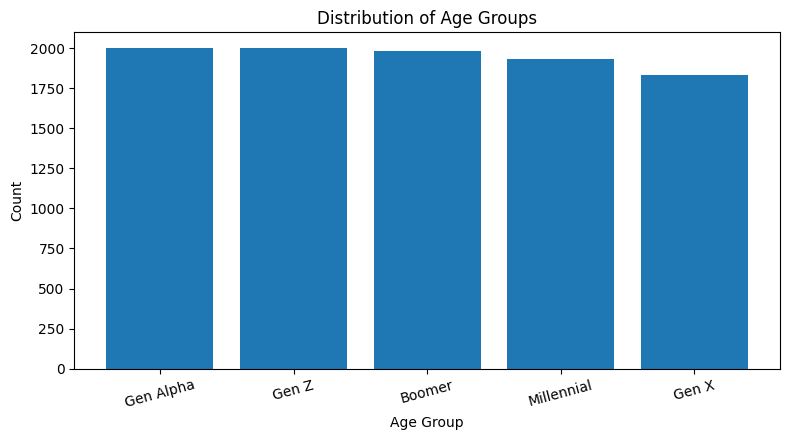

In [37]:
age_counts = df["age_group"].value_counts()
plt.figure(figsize=(8, 4.5))
plt.bar(age_counts.index.astype(str), age_counts.values)
plt.title("Distribution of Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

C:\Users\Natasha Kayla\AppData\Local\Temp\ipykernel_9104\3793409599.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


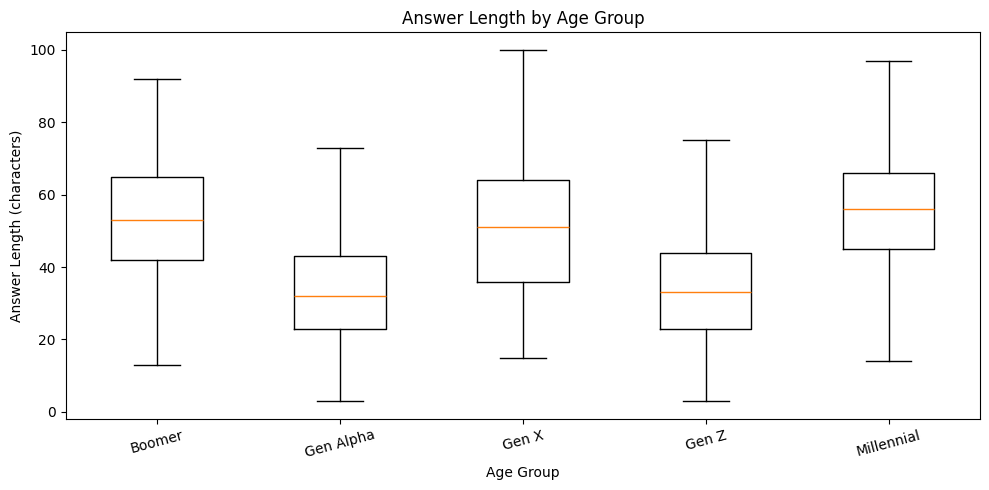

In [39]:
plt.figure(figsize=(10, 5))
groups = [g["answer_length"].values for _, g in df.sort_values("age_group").groupby("age_group")]
labels = [k for k, _ in df.sort_values("age_group").groupby("age_group")]
plt.boxplot(groups, labels=labels, showfliers=False)
plt.title("Answer Length by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Answer Length (characters)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [38]:
df["answer"] = df["answer"].astype(str)
df["answer_length"] = df["answer"].apply(len)

len_stats = (
    df.groupby("age_group")["answer_length"]
      .agg(["count", "mean", "std", "min", "median", "max"])
      .reset_index()
      .sort_values("age_group")
)
print("\n=== Answer Length Stats by Age Group ===")
print(len_stats)


=== Answer Length Stats by Age Group ===
    age_group  count       mean        std  min  median  max
0      Boomer   1985  53.118892  15.834195   13    53.0   92
1   Gen Alpha   2000  36.166000  22.718396    3    32.0  103
2       Gen X   1832  51.055131  18.558062   15    51.0  100
3       Gen Z   2000  37.230000  22.599856    3    33.0   99
4  Millennial   1936  53.989153  18.224905   13    56.0  108


# Data Splitting

In [64]:
assert {"text", "age_group"}.issubset(x.columns), f"Columns present: {x.columns.tolist()}"

In [65]:
X = x["text"].astype(str).values
y = x["age_group"].astype(str).values

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Modelling

## Pipelines (TF-IDF + Logistic Regression)

In [80]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LinearSVC())  # will be overridden per grid
])

In [68]:
param_grids = [
    # Logistic Regression
    {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__min_df": [2, 3, 5],
        "tfidf__max_df": [0.8, 0.9, 1.0],
        "tfidf__sublinear_tf": [True],
        "tfidf__stop_words": [None],  # set 'english' if fully English
        "clf": [LogisticRegression(max_iter=1000, solver="liblinear", multi_class="ovr")],
        "clf__C": [0.5, 1.0, 2.0, 5.0],
        "clf__class_weight": [None, "balanced"],
    },
    # Linear SVM (no predict_proba, but often very strong for text)
    {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__min_df": [2, 3, 5],
        "tfidf__max_df": [0.8, 0.9, 1.0],
        "tfidf__sublinear_tf": [True],
        "tfidf__stop_words": [None],
        "clf": [LinearSVC(random_state=42)],
        "clf__C": [0.5, 1.0, 2.0, 5.0],
        "clf__class_weight": [None, "balanced"],
    },
    # SGD (linear models with different losses; supports predict_proba with log_loss)
    {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__min_df": [2, 3, 5],
        "tfidf__max_df": [0.8, 0.9, 1.0],
        "tfidf__sublinear_tf": [True],
        "tfidf__stop_words": [None],
        "clf": [SGDClassifier(random_state=42)],
        "clf__loss": ["hinge", "log_loss", "modified_huber"],
        "clf__alpha": [1e-4, 1e-5],
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [2000],
    },
    # Naive Bayes (fast, strong baseline for sparse text)
    {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__min_df": [2, 3, 5],
        "tfidf__max_df": [0.8, 0.9, 1.0],
        "tfidf__sublinear_tf": [True],
        "tfidf__stop_words": [None],
        "clf": [MultinomialNB()],
        "clf__alpha": [0.1, 0.5, 1.0, 2.0],
        "clf__fit_prior": [True, False],
    },
    {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__min_df": [2, 3, 5],
        "tfidf__max_df": [0.8, 0.9, 1.0],
        "tfidf__sublinear_tf": [True],
        "tfidf__stop_words": [None],
        "clf": [ComplementNB()],
        "clf__alpha": [0.1, 0.5, 1.0, 2.0],
        "clf__fit_prior": [True, False],
    },
]

## Find Best Model (Grid Search)

In [70]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grids,
    scoring="f1_macro",        # use macro F1 for class imbalance
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True                 # refit best params on full train
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


,estimator,Pipeline(step..._iter=1000))])
,param_grid,"[{'clf': [LogisticRegre...r='liblinear')], 'clf__C': [0.5, 1.0, ...], 'clf__class_weight': [None, 'balanced'], 'tfidf__max_df': [0.8, 0.9, ...], ...}, {'clf': [LinearSVC(random_state=42)], 'clf__C': [0.5, 1.0, ...], 'clf__class_weight': [None, 'balanced'], 'tfidf__max_df': [0.8, 0.9, ...], ...}, ...]"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [71]:
print("\nBest CV score (macro F1):", grid.best_score_)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_


Best CV score (macro F1): 0.9920775186438758
Best params: {'clf': LinearSVC(random_state=42), 'clf__C': 5.0, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True}


In [72]:
cvres = pd.DataFrame(grid.cv_results_)
cvres = cvres.sort_values("mean_test_score", ascending=False)
cols = [c for c in cvres.columns if c.startswith("param_")] + ["mean_test_score","std_test_score","rank_test_score"]
print("\nTop candidates:\n", cvres[cols].head(10).to_string(index=False))


Top candidates:
                  param_clf  param_clf__C param_clf__class_weight  param_tfidf__max_df  param_tfidf__min_df param_tfidf__ngram_range param_tfidf__stop_words  param_tfidf__sublinear_tf  param_clf__alpha param_clf__loss  param_clf__max_iter param_clf__fit_prior  mean_test_score  std_test_score  rank_test_score
LinearSVC(random_state=42)           5.0                balanced                  0.9                    2                   (1, 2)                    None                       True               NaN             NaN                  NaN                  NaN         0.992078        0.001543                1
LinearSVC(random_state=42)           5.0                balanced                  1.0                    2                   (1, 2)                    None                       True               NaN             NaN                  NaN                  NaN         0.992078        0.001543                1
LinearSVC(random_state=42)           5.0               

## Evaluation

In [83]:
y_pred = best_model.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")

In [74]:
print(f"\n=== Hold-out Test ===")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1m:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== Hold-out Test ===
Accuracy : 0.9947
Macro F1 : 0.9941

Classification Report:
               precision    recall  f1-score   support

      Boomer       1.00      1.00      1.00       266
   Gen Alpha       0.99      0.98      0.99       189
       Gen X       1.00      1.00      1.00       235
       Gen Z       0.98      1.00      0.99       204
  Millennial       1.00      1.00      1.00       248

    accuracy                           0.99      1142
   macro avg       0.99      0.99      0.99      1142
weighted avg       0.99      0.99      0.99      1142



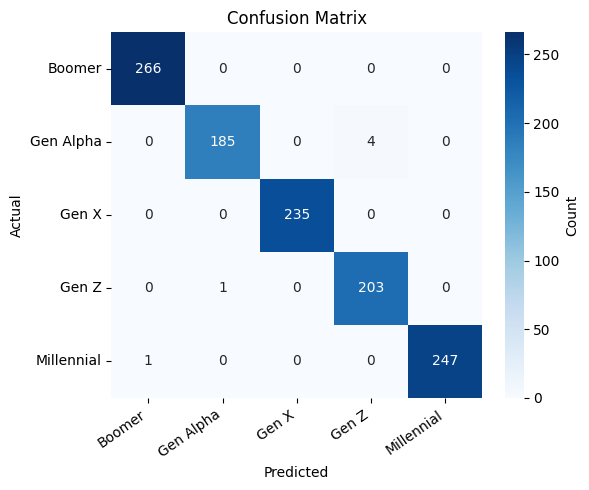

In [84]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={"label": "Count"})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=35, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# Save Best Pipeline

In [85]:
Path("models").mkdir(parents=True, exist_ok=True)
joblib.dump(best_model, "models/age_guess_best_pipeline.joblib")
print("\nSaved to models/age_guess_best_pipeline.joblib")


Saved to models/age_guess_best_pipeline.joblib
